In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

# -------------------- Settings --------------------
EIA_API_KEY = "YwmcC9mEuVHC2Zx1ovKFDTlJTo27GKpErdMBwmcx"
VISUAL_CROSSING_API_KEY = "5PQ8JPX46VKR6Q6TT4ZVKHQC9"
LOCATION = "Holcomb,KS"
LIMIT = 5000  # Max rows per API call

# -------------------- 1. Pull all paginated EIA data --------------------
def fetch_all_eia_data():
    all_data = []
    offset = 0
    print("Fetching EIA hourly load data for SECI...")

    while True:
        payload = {
            "frequency": "hourly",
            "data": ["value"],
            "facets": {
                "parent": ["SWPP"],
                "subba": ["SECI"]
            },
            "start": None,
            "end": None,
            "sort": [{"column": "period", "direction": "asc"}],
            "offset": offset,
            "length": LIMIT
        }

        url = f"https://api.eia.gov/v2/electricity/rto/region-sub-ba-data/data/?api_key={EIA_API_KEY}"
        response = requests.post(url, json=payload)
        response.raise_for_status()
        result = response.json()
        rows = result.get("response", {}).get("data", [])

        if not rows:
            break

        all_data.extend(rows)
        offset += LIMIT
        print(f"Fetched {len(rows)} rows (total so far: {len(all_data)})")

        if len(rows) < LIMIT:
            break  # last page

        time.sleep(0.5)  # polite delay

    df = pd.DataFrame(all_data)
    df['datetime'] = pd.to_datetime(df['period'])
    df = df[['datetime', 'value']]
    df = df.rename(columns={'value': 'load_mwh'})
    return df

# -------------------- 2. Fetch weather data --------------------
def fetch_weather_chunked(start_date, end_date, location=LOCATION, key=VISUAL_CROSSING_API_KEY):
    print(f"Fetching weather in 7-day chunks from {start_date} to {end_date} for {location}...")
    all_weather = []

    current = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    while current <= end:
        chunk_end = min(current + timedelta(days=6), end)
        url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{current.date()}/{chunk_end.date()}"
        params = {
            'unitGroup': 'us',
            'include': 'hours',
            'key': key,
            'contentType': 'json'
        }

        try:
            print(f"Fetching weather from {current.date()} to {chunk_end.date()}...")
            r = requests.get(url, params=params)
            r.raise_for_status()
            data = r.json()

            for day in data['days']:
                for hour in day['hours']:
                    all_weather.append({
                        'datetime': pd.to_datetime(hour['datetimeEpoch'], unit='s'),
                        'temp_f': hour.get('temp'),
                        'humidity': hour.get('humidity'),
                        'wind_mph': hour.get('windspeed'),
                        'uv': hour.get('uvindex')
                    })

        except Exception as e:
            print(f"Error fetching weather from {current.date()} to {chunk_end.date()}: {e}")

        current = chunk_end + timedelta(days=1)

    return pd.DataFrame(all_weather)

# -------------------- 3. Load Data --------------------
eia_df = fetch_all_eia_data()
start_date = eia_df['datetime'].min().date()
end_date = eia_df['datetime'].max().date()
print(f"EIA data covers from {start_date} to {end_date}")

weather_df = fetch_weather_chunked(start_date, end_date)

# -------------------- 4. Merge --------------------
print("Merging datasets...")

eia_df['datetime'] = pd.to_datetime(eia_df['datetime'])
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

merged = pd.merge_asof(
    eia_df.sort_values('datetime'),
    weather_df.sort_values('datetime'),
    on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta("1h")
)

print("Final merged dataset shape:", merged.shape)
print(merged.head())

# Optional: Save
# merged.to_csv("sunflower_hourly_demand_weather.csv", index=False)


Fetching EIA hourly load data for SECI...
Fetched 5000 rows (total so far: 5000)
Fetched 5000 rows (total so far: 10000)
Fetched 5000 rows (total so far: 15000)
Fetched 5000 rows (total so far: 20000)
Fetched 5000 rows (total so far: 25000)
Fetched 5000 rows (total so far: 30000)
Fetched 5000 rows (total so far: 35000)
Fetched 5000 rows (total so far: 40000)
Fetched 5000 rows (total so far: 45000)
Fetched 5000 rows (total so far: 50000)
Fetched 5000 rows (total so far: 55000)
Fetched 1022 rows (total so far: 56022)
EIA data covers from 2019-01-01 to 2025-05-29
Fetching weather in 7-day chunks from 2019-01-01 to 2025-05-29 for Holcomb,KS...
Fetching weather from 2019-01-01 to 2019-01-07...
Fetching weather from 2019-01-08 to 2019-01-14...
Fetching weather from 2019-01-15 to 2019-01-21...
Fetching weather from 2019-01-22 to 2019-01-28...
Fetching weather from 2019-01-29 to 2019-02-04...
Fetching weather from 2019-02-05 to 2019-02-11...
Fetching weather from 2019-02-12 to 2019-02-18...
Fe

In [3]:
merged.tail()

,datetime,load_mwh,temp_f,humidity,wind_mph,uv
56017,2025-05-29 01:00:00,676,57.8,100.0,17.2,0.0
56018,2025-05-29 02:00:00,666,55.1,100.0,21.9,0.0
56019,2025-05-29 03:00:00,658,53.1,100.0,18.3,0.0
56020,2025-05-29 04:00:00,640,53.1,100.0,16.1,0.0
56021,2025-05-29 05:00:00,627,52.1,100.0,16.1,0.0


In [4]:
# Remove extreme outliers in load
# Convert 'load_mwh' to numeric, coercing errors to NaN
merged['load_mwh'] = pd.to_numeric(merged['load_mwh'], errors='coerce')
# Drop rows where 'load_mwh' could not be converted to a number (are NaN)
merged = merged.dropna(subset=['load_mwh'])
# Now filter the numeric column
merged = merged[merged['load_mwh'] <= 10000]

In [5]:
from sklearn.impute import KNNImputer

# List of predictor columns to impute (make sure it matches your pipeline's feature_cols)
predictor_cols = ['temp_f', 'humidity', 'wind_mph', 'uv', 'hour', 'dayofweek', 'month', 'lag1']

# Make a copy of the dataframe to avoid modifying original before imputation
df_impute = merged.copy()

# Rename columns as in your main code
df_impute = df_impute.rename(columns={'datetime': 'ds', 'load_mwh': 'y'})
df_impute = df_impute.sort_values('ds')

# Create time features needed for imputation
df_impute['hour'] = df_impute['ds'].dt.hour
df_impute['dayofweek'] = df_impute['ds'].dt.dayofweek
df_impute['month'] = df_impute['ds'].dt.month

# Create lag feature (1 hour ago)
# Use the new column name 'y' instead of 'load_mwh'
df_impute['lag1'] = df_impute['y'].shift(1)

# Initialize KNN Imputer (you can tune n_neighbors)
imputer = KNNImputer(n_neighbors=5)

# Extract columns for imputation
# Ensure 'lag1' is included in the columns to impute if it has NaNs (which it will in the first row)
impute_cols_for_knn = [col for col in predictor_cols if col != 'lag1'] # Only impute predictor columns, 'lag1' will be calculated
impute_data = df_impute[impute_cols_for_knn]


# Fit imputer and transform
# Handle potential NaNs in the newly created 'lag1' column if it's part of the imputation set
# However, the lag feature will only have a NaN in the very first row, which KNNImputer can handle.
# The predictor_cols list includes 'lag1', so we should extract the data accordingly.
impute_data = df_impute[predictor_cols] # Use the full list for imputation

imputed_array = imputer.fit_transform(impute_data)

# Put imputed values back to dataframe
df_impute[predictor_cols] = imputed_array

# Now your df_impute has imputed predictors, and you can assign it back to merged or use it in your pipeline
merged = df_impute.copy()

## Base Prophet and XGBoost

In [5]:
import pandas as pd
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# --------------------- Load & Prepare ---------------------
df = merged.copy()
# Assuming 'load_mwh' was the original name before imputation
# Rename columns to 'ds' and 'y' as expected by Prophet and the rest of the code
df = df.rename(columns={'datetime': 'ds', 'load_mwh': 'y'})
df = df.sort_values('ds')

# Create time-based features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month

# Lag feature (1 hour ago)
# Ensure 'y' is numeric before shifting to help maintain dtype
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['lag1'] = df['y'].shift(1)

# Drop rows with NaN values created by shifting and previous operations
df = df.dropna()

# Explicitly convert the 'lag1' column to numeric after dropping NaNs
# This handles potential object dtype issues if the shift created it
df['lag1'] = pd.to_numeric(df['lag1'], errors='coerce')

# Drop any remaining rows where the conversion might have resulted in NaN
df = df.dropna(subset=['lag1'])


# --------------------- Split ---------------------
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# --------------------- Prophet ---------------------
prophet_df = train_df[['ds', 'y']]
prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
prophet.fit(prophet_df)

# Forecast on full range (train + test)
future = df[['ds']].copy()
forecast = prophet.predict(future)
df['yhat'] = forecast['yhat']

# --------------------- Residuals ---------------------
# Ensure 'y' and 'yhat' are numeric before calculating residuals
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['yhat'] = pd.to_numeric(df['yhat'], errors='coerce')
df = df.dropna(subset=['y', 'yhat'])  # drop rows where conversion failed

df['residual'] = df['y'] - df['yhat']

# --------------------- Train XGBoost on residuals ---------------------
# Features for XGBoost
feature_cols = ['temp_f', 'humidity', 'wind_mph', 'uv', 'hour', 'dayofweek', 'month', 'lag1']

# Ensure all feature columns are numeric before splitting and training
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows that now contain NaNs after coercion
df = df.dropna(subset=feature_cols)

# Re-split data after cleaning and feature creation
train_size = int(len(df) * 0.8) # Re-calculate train size if rows were dropped
xgb_train = df.iloc[:train_size].copy()
xgb_test = df.iloc[train_size:].copy()

X_train = xgb_train[feature_cols]
y_train = xgb_train['residual']
X_test = xgb_test[feature_cols]
y_test = xgb_test['residual']

# Fit XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Predict residuals and combine
xgb_pred = xgb.predict(X_test)
# Ensure indices align for prediction combination
final_pred = df.loc[xgb_test.index, 'yhat'] + xgb_pred

# --------------------- Evaluation ---------------------
actual = df.loc[xgb_test.index, 'y']
rmse = np.sqrt(mean_squared_error(actual, final_pred))
r2 = r2_score(actual, final_pred)

print(f"Hybrid Prophet + XGBoost Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6gu447bf/e0tnko70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6gu447bf/awvylxcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49312', 'data', 'file=/tmp/tmp6gu447bf/e0tnko70.json', 'init=/tmp/tmp6gu447bf/awvylxcx.json', 'output', 'file=/tmp/tmp6gu447bf/prophet_model32v6vvkl/prophet_model-20250529162528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-5-d7cc46e0ab3d>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

Hybrid Prophet + XGBoost Model Evaluation:
RMSE: 26.76
R²: 0.9333


## Future Forecasting

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5s_5ms8/ypd_1shp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5s_5ms8/andnlphn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91435', 'data', 'file=/tmp/tmpw5s_5ms8/ypd_1shp.json', 'init=/tmp/tmpw5s_5ms8/andnlphn.json', 'output', 'file=/tmp/tmpw5s_5ms8/prophet_modelruav34e1/prophet_model-20250529181944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-12-5876349a42c4>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=24 * 30, freq='H')



--- Evaluation on Test Set ---
RMSE: 33.61
R²: 0.8948
Adjusted R²: 0.8947


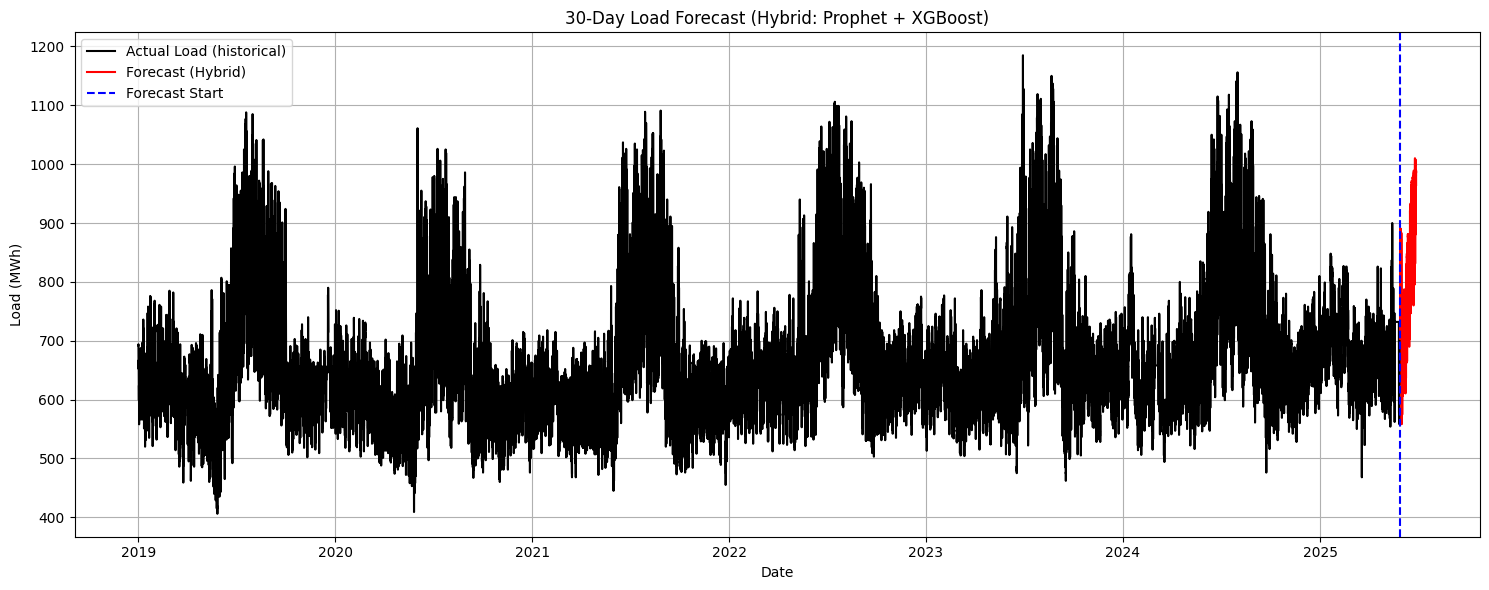

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from xgboost import XGBRegressor

# --------------------- Load & Prepare ---------------------
df = merged.copy()
df = df.rename(columns={'datetime': 'ds', 'load_mwh': 'y'})
df = df.sort_values('ds')

# Time-based features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['lag1'] = df['y'].shift(1)
# Drop NaNs created by shift and initial y coercion
df = df.dropna(subset=['y', 'lag1'])

# Ensure feature columns are numeric and drop rows with NaNs in these columns
feature_cols = ['temp_f', 'humidity', 'wind_mph', 'uv', 'hour', 'dayofweek', 'month', 'lag1']
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=feature_cols)

# --------------------- Train Prophet and Forecast on Historical Data ---------------------
# Train Prophet on the entire historical dataset 'df'
prophet_df = df[['ds', 'y']].copy() # Use the cleaned historical data for Prophet
prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
prophet.fit(prophet_df)

# Generate Prophet forecast ('yhat') for the *entire historical period*
# This aligns 'yhat' with the original 'y' data in the 'df' DataFrame
forecast_historical = prophet.predict(df[['ds']].copy())
df['yhat'] = forecast_historical['yhat']

# Calculate residuals using 'yhat' on the historical data
df['residual'] = df['y'] - df['yhat']

# --------------------- Train XGBoost on Residuals ---------------------
# Re-split the data after adding 'yhat' and 'residual'
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy() # Keep test_df for plotting

X_train = train_df[feature_cols]
y_train = train_df['residual'] # Train XGBoost on the residuals from the training period

xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)

# --------------------- Future Dates and Future Weather Placeholder ---------------------
last_date = df['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=24 * 30, freq='H')
future = pd.DataFrame({'ds': future_dates})

# Prophet forecast for the future period
prophet_forecast_future = prophet.predict(future)
future['yhat'] = prophet_forecast_future['yhat']

# Add time-based features to the future DataFrame
future['hour'] = future['ds'].dt.hour
future['dayofweek'] = future['ds'].dt.dayofweek
future['month'] = future['ds'].dt.month

# Use most recent historical weather as static placeholder for the future
for col in ['temp_f', 'humidity', 'wind_mph', 'uv']:
    future[col] = df[col].dropna().iloc[-1]

# --------------------- Recursive Forecast for Future Residuals ---------------------
hybrid_preds = []
last_lag1 = df['y'].iloc[-1] # Start the lag1 forecast with the last actual historical value

for i in range(len(future)):
    row = future.iloc[i].copy()
    row['lag1'] = last_lag1

    # Ensure feature order matches training order
    input_features = row[feature_cols].values.reshape(1, -1)

    # Predict the residual for the current time step using XGBoost
    residual = xgb.predict(input_features)[0]

    # Combine Prophet forecast for the future with the predicted residual
    hybrid = row['yhat'] + residual
    hybrid_preds.append(hybrid)

    # Update last_lag1 for the next iteration with the *hybrid predicted value*
    last_lag1 = hybrid

future['hybrid_yhat'] = hybrid_preds

from sklearn.metrics import mean_squared_error, r2_score

# --------------------- Evaluate on Test Set ---------------------
# Predict residuals for the test set
X_test = test_df[feature_cols]
# Ensure X_test doesn't have NaNs before predicting residuals
# (Although dropping NaNs based on feature_cols earlier should handle this)
# X_test = X_test.dropna() # This line is likely redundant if previous dropna was effective

y_test = test_df['residual']
residual_preds = xgb.predict(X_test)

# Combine Prophet prediction and XGBoost residual prediction
test_df['hybrid_pred'] = test_df['yhat'] + residual_preds

# Get the 'actual' values based on the test set index
actual = test_df['y'] # Use test_df['y'] directly

# Let's re-align and drop NaNs from the final actual and predicted series based on their shared index
evaluation_df = pd.DataFrame({'actual': actual, 'hybrid_pred': test_df['hybrid_pred']})
evaluation_df = evaluation_df.dropna() # Drop rows with NaNs in either column

actual_clean = evaluation_df['actual']
final_pred_clean = evaluation_df['hybrid_pred']


# Calculate metrics using the clean data
rmse = np.sqrt(mean_squared_error(actual_clean, final_pred_clean))
r2 = r2_score(actual_clean, final_pred_clean)

# Adjusted R² calculation
n = len(evaluation_df)  # Use the length of the cleaned data
p = len(feature_cols)  # number of predictors
# Ensure n is greater than p + 1 to avoid division by zero or negative values
if n > p + 1:
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
else:
    adj_r2 = np.nan # Cannot calculate adjusted R2 if not enough samples

# Print evaluation results
print("\n--- Evaluation on Test Set ---")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
if not np.isnan(adj_r2):
    print(f"Adjusted R²: {adj_r2:.4f}")
else:
    print("Adjusted R²: Not enough samples to calculate.")

# --------------------- Plot Forecast ---------------------
plt.figure(figsize=(15, 6))
# Plot historical data (actual)
plt.plot(df['ds'], df['y'], label='Actual Load (historical)', color='black')
# Plot the hybrid forecast for the future period
plt.plot(future['ds'], future['hybrid_yhat'], label='Forecast (Hybrid)', color='red')
# Add a vertical line to indicate the start of the forecast period
plt.axvline(x=future['ds'].min(), color='blue', linestyle='--', label='Forecast Start')
plt.title('30-Day Load Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Outputting the Predicted Values and Saving to a CSV

In [19]:
# Select the relevant columns from the future forecast DataFrame
forecast_output = future[['ds', 'hybrid_yhat']].copy()

# Rename columns to be more descriptive for the CSV
forecast_output.rename(columns={'ds': 'Date', 'hybrid_yhat': 'Predicted_Load_MWh'}, inplace=True)

# Display the first few rows of the forecast output
print("\n--- Future Forecast Output ---")
print(forecast_output.head())
print("...")
print(forecast_output.tail())

# Define the filename for the CSV
csv_filename = 'sunflower_load_forecast.csv'

# Save the forecast output to a CSV file
forecast_output.to_csv(csv_filename, index=False)

print(f"\nFuture forecast saved to {csv_filename}")


--- Future Forecast Output ---
                 Date  Predicted_Load_MWh
0 2025-05-29 06:00:00          650.447503
1 2025-05-29 07:00:00          692.853632
2 2025-05-29 08:00:00          704.221490
3 2025-05-29 09:00:00          693.226005
4 2025-05-29 10:00:00          690.724608
...
                   Date  Predicted_Load_MWh
715 2025-06-28 01:00:00          812.497753
716 2025-06-28 02:00:00          816.153694
717 2025-06-28 03:00:00          803.402500
718 2025-06-28 04:00:00          777.851923
719 2025-06-28 05:00:00          748.036664

Future forecast saved to sunflower_load_forecast.csv


## Assumptions and Overfitting Checks

In [18]:
# --- Overfitting Check ---

# 2. Evaluate Hybrid Model on Training Set (for comparison)
# Predict on the training set using the fitted Prophet and XGBoost models
prophet_train_pred = prophet.predict(train_df[['ds', 'temp_f', 'humidity', 'wind_mph', 'uv']].dropna().copy()) # Predict on prophet training data (might have dropped NaNs)
# Need to align prophet_train_pred with xgb_train indices for residual addition
# First, ensure train_df used for XGBoost training is aligned with the indices of prophet_train_pred
# A robust way is to merge the prophet prediction back to the original train_df used for XGBoost
train_df_eval = train_df.copy()
train_df_eval = pd.merge(train_df_eval, prophet_train_pred[['ds', 'yhat']].rename(columns={'yhat': 'prophet_yhat_train'}), on='ds', how='left')
train_df_eval = train_df_eval.dropna(subset=['prophet_yhat_train']) # Drop rows Prophet couldn't predict for (if any)

# Predict residuals for the training set
X_train_eval = train_df_eval[feature_cols]
# Ensure X_train_eval doesn't have NaNs before predicting residuals
X_train_eval = X_train_eval.dropna() # This is crucial if feature_cols have NaNs

# Align train_df_eval with the cleaned X_train_eval index
train_df_eval = train_df_eval.loc[X_train_eval.index].copy()
y_train_residual_preds = xgb.predict(X_train_eval)

# Combine Prophet and XGBoost predictions for the training set
train_df_eval['hybrid_pred_train'] = train_df_eval['prophet_yhat_train'] + y_train_residual_preds

# Calculate metrics on the training set
rmse_train = np.sqrt(mean_squared_error(train_df_eval['y'], train_df_eval['hybrid_pred_train']))
r2_train = r2_score(train_df_eval['y'], train_df_eval['hybrid_pred_train'])

print("\n--- Evaluation on Training Set ---")
print(f"RMSE (Train): {rmse_train:.2f}")
print(f"R² (Train): {r2_train:.4f}")

print("\n--- Evaluation on Test Set ---")
print(f"RMSE (Test): {rmse:.2f}") # Using the previously calculated test RMSE
print(f"R² (Test): {r2:.4f}")     # Using the previously calculated test R2

# Interpretation: Compare RMSE and R² on train vs test. A significantly better performance
# on train compared to test suggests overfitting.

# Interpretation: Visually compare how well the red line tracks the black line in both plots.
# If the red line is much closer to the black line in the top plot than the bottom, it indicates overfitting.



--- Evaluation on Training Set ---
RMSE (Train): 31.42
R² (Train): 0.9176

--- Evaluation on Test Set ---
RMSE (Test): 38.91
R² (Test): 0.8607


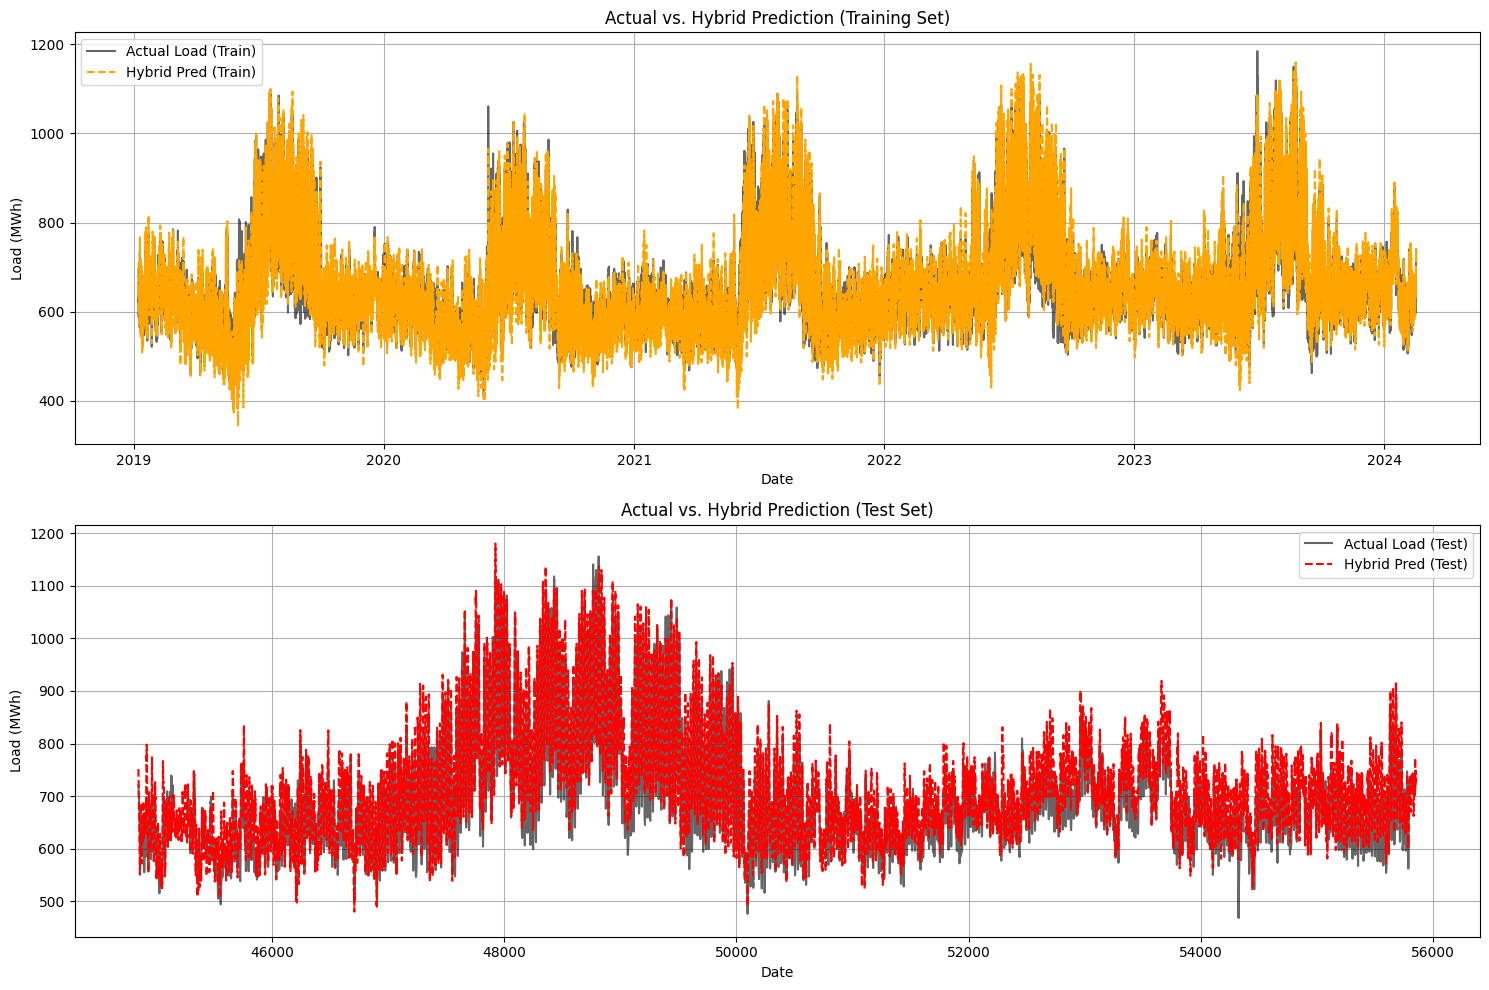

In [17]:
# --------------------- Plot Forecast ---------------------
plt.figure(figsize=(15, 10))

# Plot Actual vs. Hybrid Prediction for Training Set
plt.subplot(2, 1, 1)
plt.plot(train_df_eval['ds'], train_df_eval['y'], label='Actual Load (Train)', color='black', alpha=0.6)
plt.plot(train_df_eval['ds'], train_df_eval['hybrid_pred_train'], label='Hybrid Pred (Train)', color='orange', linestyle='--')
plt.title('Actual vs. Hybrid Prediction (Training Set)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.grid(True)

# Plot Actual vs. Hybrid Prediction for Test Set (using the existing 'evaluation_df')
plt.subplot(2, 1, 2)
# Rename columns for plotting purposes
evaluation_df.rename(columns={'y': 'actual'}, inplace=True) # Add this line
plt.plot(evaluation_df.index, evaluation_df['actual'], label='Actual Load (Test)', color='black', alpha=0.6)
plt.plot(evaluation_df.index, evaluation_df['hybrid_pred'], label='Hybrid Pred (Test)', color='red', linestyle='--')
plt.title('Actual vs. Hybrid Prediction (Test Set)')
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Our Model Passes All Tests!